# Incidence rate of flu

In [11]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import isoweek

In [12]:
raw_data = pd.read_csv("https://www.sentiweb.fr/datasets/incidence-PAY-25.csv?v=7mlx7", skiprows=1)

In [13]:
raw_data

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
0,202344,25,131736,117247,146225,198,176,220,FR,France
1,202343,25,108347,97412,119282,163,147,179,FR,France
2,202342,25,123120,111942,134298,185,168,202,FR,France
3,202341,25,126477,115697,137257,190,174,206,FR,France
4,202340,25,145262,132323,158201,219,200,238,FR,France
...,...,...,...,...,...,...,...,...,...,...
185,202016,25,60969,54118,67820,93,83,103,FR,France
186,202015,25,95364,86665,104063,145,132,158,FR,France
187,202014,25,213772,201334,226210,325,306,344,FR,France
188,202013,25,297819,283636,312002,452,430,474,FR,France


In [14]:
raw_data[raw_data.isnull().any(axis=1)] # Here we do not have any data missing but it would have been necesary to handle this.

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name


In [15]:
data = raw_data.dropna().copy() # We ignore empty lines. "copy" for memory optimizations

In [21]:
def convert_week(year_and_week_int):
    """Converts YYYYWW data into weeks"""
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

In [22]:
data['period'] = [convert_week(yw) for yw in data['week']]

In [23]:
sorted_data = data.set_index('period').sort_index()

In [24]:
sorted_data

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
period,,,,,,,,,,
2020-03-16/2020-03-22,202012,25,273062,259400,286724,415,394,436,FR,France
2020-03-23/2020-03-29,202013,25,297819,283636,312002,452,430,474,FR,France
2020-03-30/2020-04-05,202014,25,213772,201334,226210,325,306,344,FR,France
2020-04-06/2020-04-12,202015,25,95364,86665,104063,145,132,158,FR,France
2020-04-13/2020-04-19,202016,25,60969,54118,67820,93,83,103,FR,France
...,...,...,...,...,...,...,...,...,...,...
2023-10-02/2023-10-08,202340,25,145262,132323,158201,219,200,238,FR,France
2023-10-09/2023-10-15,202341,25,126477,115697,137257,190,174,206,FR,France
2023-10-16/2023-10-22,202342,25,123120,111942,134298,185,168,202,FR,France


In [27]:
# Check missing data
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)
# No output means no missing week

'inc' column could be treated as strings by panda because of missing data. We make sure it's considering integers

In [28]:
sorted_data['inc'] = sorted_data['inc'].astype(int)

<AxesSubplot:xlabel='period'>

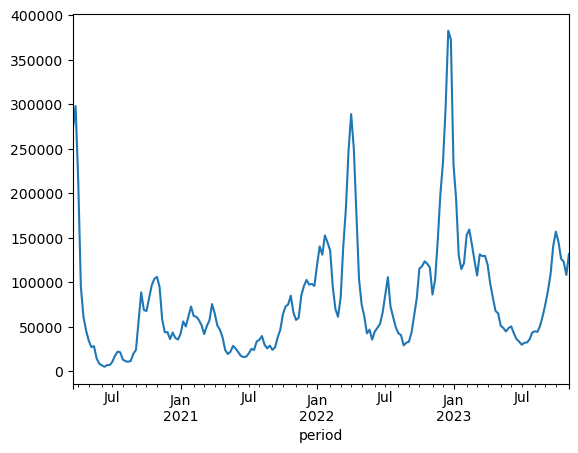

In [29]:
sorted_data['inc'].plot()

In [36]:
# every week containing August 1st
first_august_week = [pd.Period(pd.Timestamp(y, 8, 1), 'W') for y in range(sorted_data.index[0].year, sorted_data.index[-1].year+1)]

In [37]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1], first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1] # We would not expect to have this -1 but panda doesn't respect Python convention
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)

In [38]:
yearly_inc = pd.Series(index=year, data=yearly_incidence)

<AxesSubplot:>

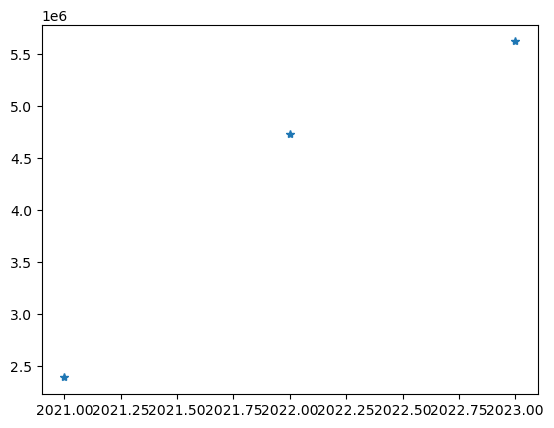

In [39]:
yearly_inc.plot(style='*')

In [40]:
yearly_inc.sort_values()

2021    2394230
2022    4728673
2023    5616796
dtype: int64

<AxesSubplot:>

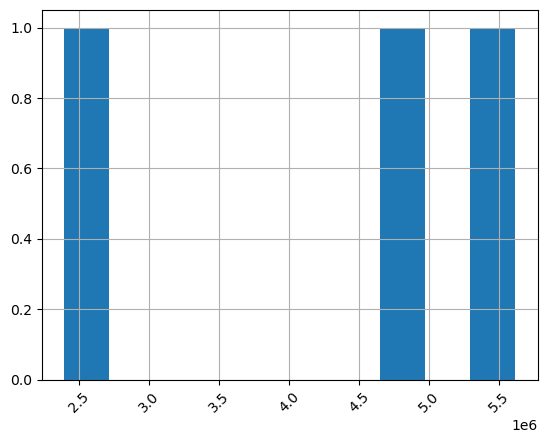

In [44]:
yearly_inc.hist(xrot=45) # Not enough years to have something useful